# 2. LTV_EDA — Exploratory Data Analysis

**Что делаем в этом ноутбуке:**
- Анализ динамики продаж и сезонности
- Распределения ключевых метрик
- Анализ статусов заказов и отмен
- Корреляционный анализ
- RFM-анализ с обработкой выбросов и лог-трансформацией
- Бизнес-инсайты и рекомендации

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os
from scipy.stats.mstats import winsorize
from scipy.stats import skew

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

In [5]:
#  Пути к данным 
PROCESSED_PATH = 'data/processed'

# Автоматический поиск файла
possible_paths = [
    os.path.join(PROCESSED_PATH,
                 'orders_full.csv'), '../data/processed/orders_full.csv',
    '../../data/processed/orders_full.csv', 'orders_full.csv'
]

data_path = None
for p in possible_paths:
    if os.path.exists(p):
        data_path = p
        break

if data_path is None:
    raise FileNotFoundError(
        "Не найден orders_full.csv. Проверьте путь к processed данным.")

print(f"Загружаем данные из: {data_path}")
orders_full = pd.read_csv(data_path)

# Преобразование дат
orders_full['order_purchase_timestamp'] = pd.to_datetime(
    orders_full['order_purchase_timestamp'])

Загружаем данные из: data/processed/orders_full.csv


## 1. Базовая информация о датасете

In [6]:
print("Размер датасета:", orders_full.shape)
print("\nТипы данных:")
display(orders_full.dtypes.to_frame('dtype'))
print("\nПропуски:")
display(orders_full.isna().sum().to_frame('missing').query('missing > 0'))

Размер датасета: (119143, 38)

Типы данных:


,dtype
order_id,object
customer_id,object
order_status,object
order_purchase_timestamp,datetime64[ns]
order_approved_at,object
order_delivered_carrier_date,object
order_delivered_customer_date,object
order_estimated_delivery_date,object
customer_unique_id,object
customer_city,object



Пропуски:


,missing
order_approved_at,177
order_delivered_carrier_date,2086
order_delivered_customer_date,3421
order_item_id,833
product_id,833
seller_id,833
shipping_limit_date,833
price,833
freight_value,833
payment_sequential,3


## 2. Динамика заказов и выручки

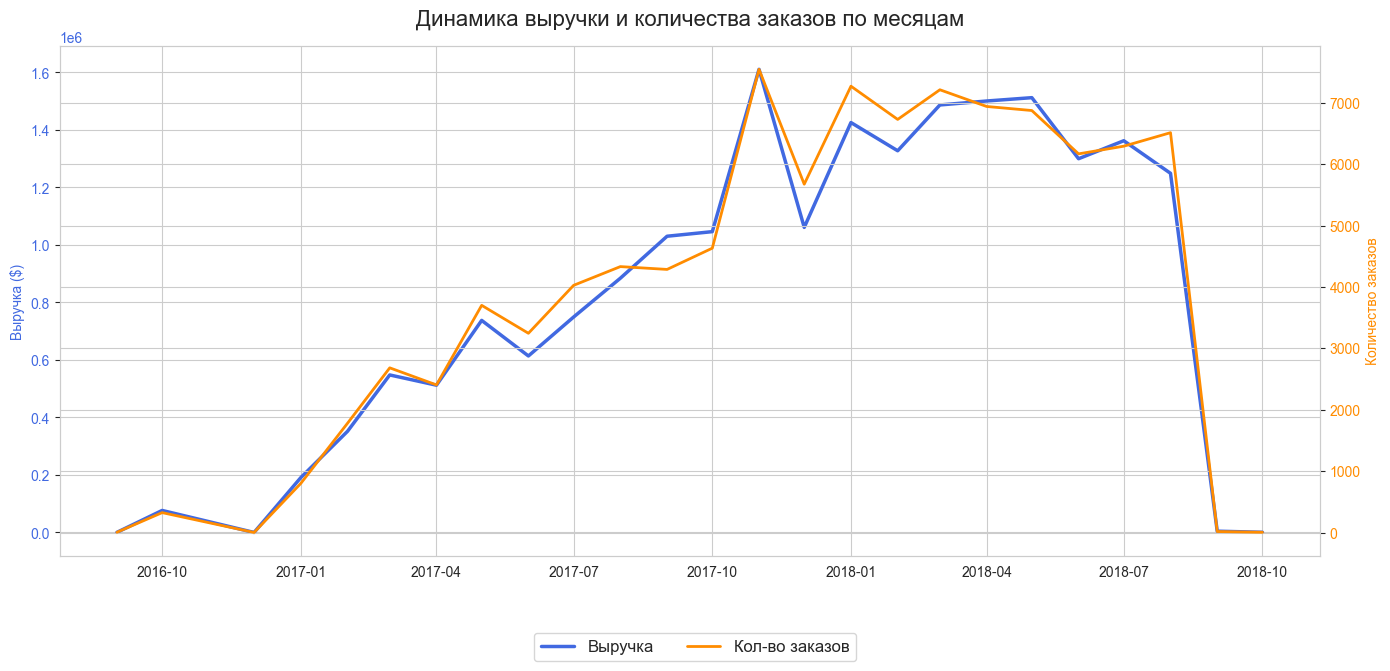

In [8]:
# Группируем по месяцу
monthly = orders_full.groupby(
    orders_full['order_purchase_timestamp'].dt.to_period('M').astype(str)).agg(
        {
            'order_id': 'nunique',
            'payment_value': 'sum',
            'customer_unique_id': 'nunique'
        }).rename(
            columns={
                'order_id': 'orders',
                'payment_value': 'revenue',
                'customer_unique_id': 'customers'
            })

monthly.index = pd.to_datetime(monthly.index)

# Визуализация
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(monthly.index,
         monthly['revenue'],
         color='royalblue',
         linewidth=2.5,
         label='Выручка')
ax1.set_ylabel('Выручка ($)', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')

ax2 = ax1.twinx()
ax2.plot(monthly.index,
         monthly['orders'],
         color='darkorange',
         linewidth=2,
         label='Кол-во заказов')
ax2.set_ylabel('Количество заказов', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

plt.title('Динамика выручки и количества заказов по месяцам',
          fontsize=16,
          pad=15)
fig.legend(loc='upper center',
           bbox_to_anchor=(0.5, -0.05),
           ncol=2,
           fontsize=12)
plt.tight_layout()
plt.show()

## 3. Анализ статусов заказов

/var/folders/h2/dsmg5l1j0ts5vnwjkk8_hcy40000gn/T/ipykernel_21730/4047259964.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=status_counts, x='percent', y='status', palette='viridis')


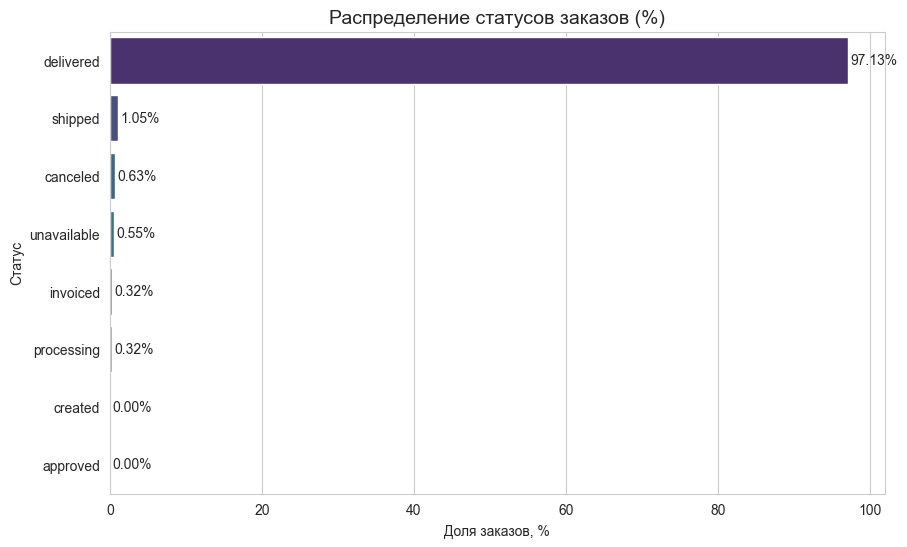

Доля отменённых / недоставленных заказов: 1.18%


In [13]:
status_counts = orders_full['order_status'].value_counts(normalize=True) * 100
status_counts = status_counts.reset_index().rename(columns={
    'proportion': 'percent',
    'order_status': 'status'
})

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(data=status_counts, x='percent', y='status', palette='viridis')
plt.title('Распределение статусов заказов (%)', fontsize=14)
plt.xlabel('Доля заказов, %')
plt.ylabel('Статус')

# Подписи процентов на столбцах
for i, v in enumerate(status_counts['percent']):
    plt.text(v + 0.3, i, f'{v:.2f}%', va='center')

plt.show()

# Вывод доли отменённых / недоставленных 
canceled_unavailable_percent = status_counts.query(
    "status in ['canceled', 'unavailable']")['percent'].sum()
print("Доля отменённых / недоставленных заказов: "
      f"{canceled_unavailable_percent:.2f}%")

## 4. Распределения ключевых денежных метрик

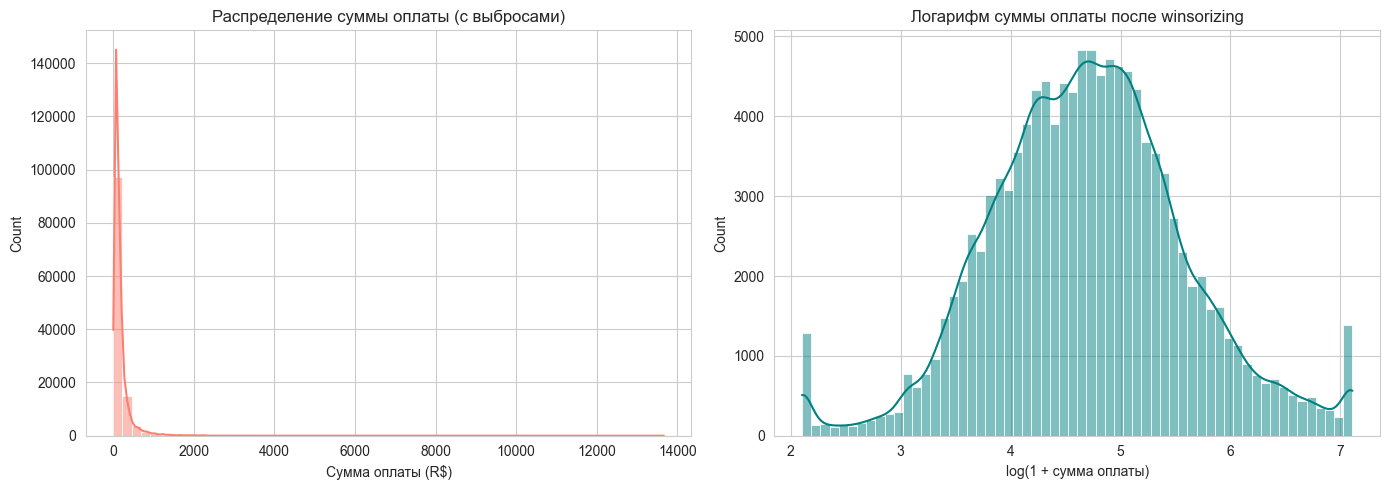

In [14]:
# Winsorize — убираем экстремальные выбросы (1% с каждой стороны)
orders_full['payment_value_winsor'] = winsorize(
    orders_full['payment_value'].fillna(0), limits=[0.01, 0.01])
orders_full['price_winsor'] = winsorize(orders_full['price'].fillna(0),
                                        limits=[0.01, 0.01])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Оригинал vs Winsorized + log
sns.histplot(orders_full['payment_value'],
             kde=True,
             ax=axes[0],
             bins=60,
             color='salmon')
axes[0].set_title('Распределение суммы оплаты (с выбросами)')
axes[0].set_xlabel('Сумма оплаты (R$)')

sns.histplot(np.log1p(orders_full['payment_value_winsor']),
             kde=True,
             ax=axes[1],
             bins=60,
             color='teal')
axes[1].set_title('Логарифм суммы оплаты после winsorizing')
axes[1].set_xlabel('log(1 + сумма оплаты)')

plt.tight_layout()
plt.show()

## 5. RFM-анализ

In [15]:
#  RFM — Recency, Frequency, Monetary
ref_date = orders_full['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

rfm = orders_full.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': [
        lambda x: (ref_date - x.max()).days,           # Recency
        'count'                                        # Frequency (кол-во заказов)
    ],
    'payment_value': 'sum'                             # Monetary
})

rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm.reset_index()

# Обработка выбросов
rfm['monetary_winsor'] = winsorize(rfm['monetary'], limits=[0.01, 0.01])
rfm['monetary_log'] = np.log1p(rfm['monetary_winsor'])

# Skewness
print("Skewness:")
print(rfm[['recency', 'frequency', 'monetary', 'monetary_log']].skew())

# Percentiles
print("\nRFM Percentiles:")
display(rfm[['recency', 'frequency', 'monetary']].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

Skewness:
recency          0.445457
frequency       15.512999
monetary        68.006427
monetary_log     0.603524
dtype: float64

RFM Percentiles:


,recency,frequency,monetary
0.25,164.0,1.0,64.0000
0.50,269.0,1.0,113.3400
0.75,398.0,1.0,203.4225
0.90,517.0,2.0,406.8400
0.95,571.0,2.0,669.0400
0.99,626.0,4.0,1714.3055


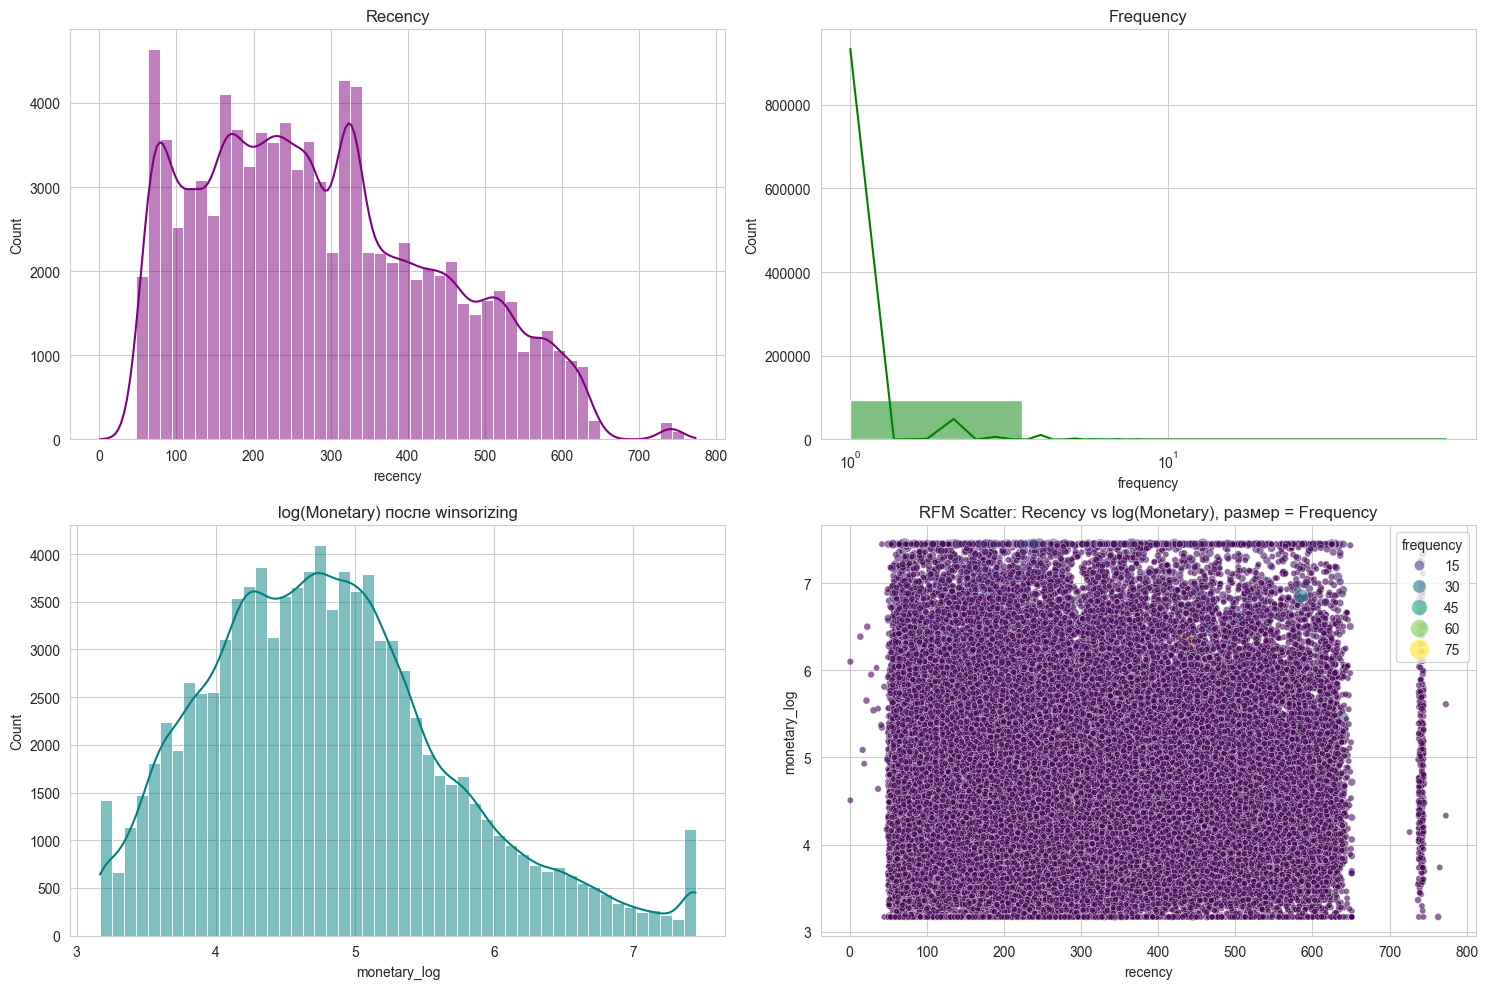

In [16]:
# Визуализация RFM
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(rfm['recency'], kde=True, bins=50, color='purple')
plt.title('Recency')

plt.subplot(2, 2, 2)
sns.histplot(rfm['frequency'], kde=True, bins=30, color='green')
plt.title('Frequency')
plt.xscale('log')

plt.subplot(2, 2, 3)
sns.histplot(rfm['monetary_log'], kde=True, bins=50, color='teal')
plt.title('log(Monetary) после winsorizing')

plt.subplot(2, 2, 4)
sns.scatterplot(data=rfm,
                x='recency',
                y='monetary_log',
                hue='frequency',
                size='frequency',
                sizes=(20, 200),
                alpha=0.6,
                palette='viridis')
plt.title('RFM Scatter: Recency vs log(Monetary), размер = Frequency')

plt.tight_layout()
plt.show()

## 6. Корреляционный анализ

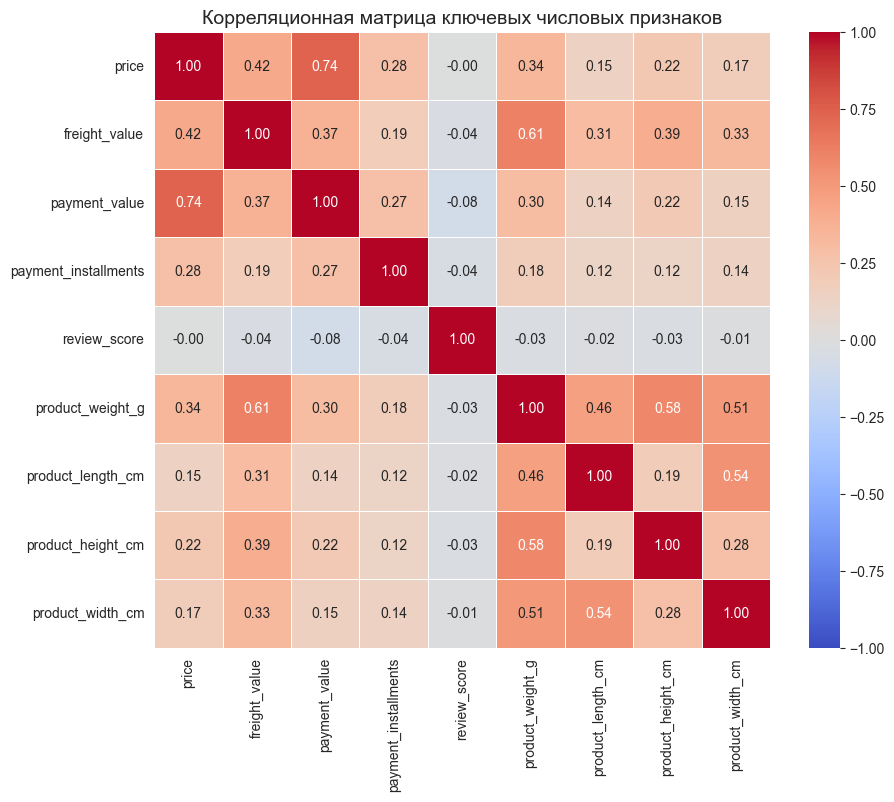

In [17]:
# Выбираем числовые признаки
num_cols = [
    'price', 'freight_value', 'payment_value', 'payment_installments',
    'review_score', 'product_weight_g', 'product_length_cm',
    'product_height_cm', 'product_width_cm'
]

corr = orders_full[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            linewidths=0.5,
            square=True)
plt.title('Корреляционная матрица ключевых числовых признаков', fontsize=14)
plt.show()

## 7.Ключевые выводы из EDA

- **Сезонность** — пик продаж в 2-й половине года (особенно май–октябрь), спад в начале года. Рекомендация: планировать маркетинговые активности и запасы на Q2–Q4.
- **Статусы заказов** — отменено ~0.6–1%, недоставлено ~0.5%. Это низкий показатель, но всё равно ~1000–1500 заказов в год. Потенциал экономии ~150–300 тыс.p в год при снижении отмен.
- **Частота покупок** — > 95% клиентов совершили только 1 покупку. Это критический сигнал: retention практически отсутствует. Основной фокус бизнеса должен быть на программах лояльности, повторных покупках, персонализированных рассылках.
- **Средний чек** — большинство покупок до ~200 p, но есть длинный хвост до 100k+. После winsorize и log-трансформации распределение становится близким к нормальному — это важно для будущих моделей.
- **Корреляции** — сильная связь между весом/размерами товара и стоимостью доставки. Цена товара слабо коррелирует с рейтингом (review_score). Можно рассмотреть отдельную модель для предсказания отмен по размеру/весу товара.
- **Выбросы** — в monetary и payment_value есть экстремальные значения (до 100k+). Winsorizing на уровне 1% сильно улучшает распределение.

